# Google Trends in AQL

In this notebook, we inspect the most prominent queries with respect to certain time windows and compare them to the most frequent queries from google in that same time window.
## 1. Annual Analysis
First, we look at the most frequent queries in a year. We examine the years from 1999 up to 2022.

Let's load the annual top 25 queries from google:

In [ ]:
import pandas as pd

annual_google_trends = pd.read_csv("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/google_trends/google_trends_total.csv")

# print(annual_google_trends['year'].unique())
# print(annual_google_trends.columns)
# for i in range(2004, 2021):
    # print(i, annual_google_trends[annual_google_trends['year'] == i])
# print(annual_google_trends)

2004           query  score  year
450        free    100  2004
451      lyrics     66  2004
452     windows     47  2004
453       music     35  2004
454       yahoo     35  2004
455         dvd     35  2004
456         mp3     34  2004
457       games     33  2004
458         web     26  2004
459         msn     25  2004
460        news     24  2004
461        ebay     21  2004
462        test     21  2004
463       linux     20  2004
464     weather     18  2004
465        love     17  2004
466        sony     17  2004
467       crack     17  2004
468        java     17  2004
469       flash     17  2004
470        chat     16  2004
471     hotmail     16  2004
472   microsoft     16  2004
473  dictionary     14  2004
474      cheats     14  2004
2005           query  score  year
425        free    100  2005
426    download     77  2005
427      lyrics     73  2005
428       yahoo     43  2005
429         msn     36  2005
430       games     35  2005
431       music     34  2005
432 

Now, we load the annual top 25 queries, the annual top 25 english queries and the annual top 25 google queries from the aql:

In [49]:
annual_aql_trends = pd.read_parquet("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-get-annual-top-queries-special")
annual_aql_trends_eng = pd.read_parquet("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-get-annual-top-queries-english")
annual_aql_trends_google = pd.read_parquet("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-get-annual-top-queries-google")


annual_aql_trends.rename(columns={'serp_query_text_url': 'query', 'count()': 'score'}, inplace=True)
annual_aql_trends_eng.rename(columns={'serp_query_text_url': 'query', 'count()': 'score'}, inplace=True)
annual_aql_trends_google.rename(columns={'serp_query_text_url': 'query', 'count()': 'score'}, inplace=True)
# print(annual_aql_trends.columns)
print(annual_aql_trends['score'].sum())
aql_top_queries = {}
aql_top_queries.update({'aql_google': annual_aql_trends_google})
aql_top_queries.update({'aql_english': annual_aql_trends_eng})
aql_top_queries.update({'aql_native': annual_aql_trends})


83543021


Let's find out if we have intersections in the annual top 25 of both query logs:

In [50]:

# transform counts into scores by assigning a score of 100 to the most frequent query of each year and compute the ratio of the other queries
sizes = {}
for key, data in aql_top_queries.items():
    print(f"AQL {key.upper()}:")
    years = set(list(data['year']))
    sizes.update({f"{key}_count": [data['score'].sum(), 100*data['score'].sum()/346310968]})
    for year in years:
        # print(year)
        max_count = data[data['year'] == year]['score'].max()
        data.loc[data['year'] == year, 'score'] = round(data.loc[data['year'] == year, 'score'] / max_count * 100)
        # print(year)

    years = set(list(data['year']))
    for year in years:
        if year >= 2004:
            aql_queries = set(data[data['year'] == year]['query'].reset_index(drop=True))
            google_queries = set(annual_google_trends[annual_google_trends['year'] == year]['query'].reset_index(drop=True))
            # google_queries_set = set(google_queries)
            # find matching queries
            matches = google_queries.intersection(aql_queries)
            # print the matching queries
            print(f"{year}: {matches}")

for key,value in sizes.items():
    print(f"{key}: {value}")    


AQL AQL_GOOGLE:
2004: set()
2005: set()
2006: set()
2007: set()
2008: set()
2009: set()
2010: set()
2011: set()
2012: {'youtube', 'facebook', 'google'}
2013: {'youtube', 'yahoo', 'facebook', 'google'}
2014: set()
2015: set()
2016: set()
2017: set()
2018: set()
2019: set()
2020: set()
2021: set()
2022: set()
AQL AQL_ENGLISH:
2004: set()
2005: set()
2006: set()
2007: set()
2008: set()
2009: set()
2010: set()
2011: set()
2012: set()
2013: set()
2014: set()
2015: set()
2016: set()
2017: set()
2018: set()
2019: set()
2020: set()
2021: set()
2022: set()
AQL AQL_NATIVE:
2004: {'free'}
2005: set()
2006: set()
2007: {'video'}
2008: set()
2009: set()
2010: set()
2011: {'you'}
2012: {'google'}
2013: set()
2014: set()
2015: set()
2016: set()
2017: set()
2018: set()
2019: set()
2020: set()
2021: set()
2022: set()
aql_google_count: [16596750, 4.792441341332279]
aql_english_count: [2412914, 0.6967477853603528]
aql_native_count: [83543021, 24.123700581149368]


As we can see, there are only few intersections in the annual top 25 queries of google and the aql queries. 

## 2. Monthly Analysis

We have loaded the top 25 queries of each month from 2005 until 2022 from google. In this analysis we want to compare the actual courses of query frequencies from the AQL and Google. For this, we first need to make a selection which queries we want for that analysis. We take the top 25 queries of the most frequent monthly queries from google. This set is obtained by applying [reciprocal rank fusion](https://dl.acm.org/doi/abs/10.1145/1571941.1572114) to the list of the top 25 monthly queries from 2005 - 2022 by google. 
First, we load google trends data:  

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np

# this function groups the data by query and computes the reciprocal rank fusion score for each query 
def get_rrf_score(data: pd.DataFrame) -> pd.DataFrame:
    data = data.groupby('query').agg(rrf_score=pd.NamedAgg(column='rank', aggfunc=lambda x: np.sum(1/(60+x)))).reset_index()
    return data.sort_values('rrf_score', ascending=False)

base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/google_trends/monthly")

data = pd.DataFrame()
for path in base_path.iterdir():
    if path.is_file():
        df = pd.read_csv(path)
        data = pd.concat([data, df])

print(data)
print(data.shape)
print(list(get_rrf_score(data)['query'].head(50)))


               query  score  rank
0           facebook    100     1
1             google     51     2
2            youtube     49     3
3                you     29     4
4               news     17     5
...              ...    ...   ...
5695  facebook login      8    21
5696              as      8    22
5697            ebay      8    23
5698              dr      8    24
5699           apple      8    25

[5700 rows x 3 columns]
(5700, 3)
['google', 'yahoo', 'weather', 'youtube', 'hotmail', 'facebook', 'gmail', 'news', 'you', 'ebay', 'amazon', 'games', 'free', 'twitter', 'translate', 'mp3', 'maps', 'msn', 'fb', 'mail', 'instagram', 'map', 'face', 'video', 'juegos', 'craigslist', 'facebook login', 'lyrics', 'game', 'traductor', 'you tube', 'as', 'whatsapp', 'videos', 'wikipedia', 'yahoo mail', 'myspace', 'tiempo', 'samsung', 'bbc', 'meteo', 'web', 'music', 'nokia', 'погода', 'clima', 'chat', 'sony', 'download', 'go']


After we have collected the top 100 monthly queries from google, we also have retrieved them in the AQL and grouped by their timestamp (in YYYY-MM). Let's load the results:

In [3]:
import pandas as pd
top_25 = ['google', 'yahoo', 'weather', 'youtube', 'hotmail', 'facebook', 'gmail', 'news', 'you', 'ebay', 'amazon', 'games', 'free', 'twitter', 'translate', 'mp3', 'maps', 'msn', 'fb', 'mail', 'instagram', 'map', 'face', 'video', 'juegos']
monthly_aql_trends = pd.read_parquet("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-top-monthly-queries-over-time")

In [4]:
# rename col to 'query'
monthly_aql_trends = monthly_aql_trends.rename(columns={'serp_query_text_url': 'query'})

# get top 25
monthly_aql_trends25 = monthly_aql_trends[monthly_aql_trends['query'].isin(top_25)]

# convert str to datetime
monthly_aql_trends25['time'] = pd.to_datetime(monthly_aql_trends25['time'])

# split the data in terms of queries
aql_google_data = {}
for query in top_25:
    aql_google_data.update({query: monthly_aql_trends25[monthly_aql_trends25['query'] == query]})


/tmp/ipykernel_186270/464582132.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_aql_trends25['time'] = pd.to_datetime(monthly_aql_trends25['time'])


### Preprocessing
Before computing the correlation, we need to undertake a few steps to make the data comparable. 

1. Fill empty time slots with the count 0
2. Compute the query popularity by taking the ratio of a query's count at a given time and the overall count of google queries in the AQL at that time.
3. Project the time series to the interval [0,100].



In [5]:
# 1. Fill empty months with 0

# for each query, fill the missing months between 2004 and 2021 with 0
for query in aql_google_data.keys():
    # create a date range between 2004 and 2021
    date_range = pd.date_range(start='2004-01-01', end='2022-12-01', freq='MS')
    # create a new dataframe with the date range
    new_df = pd.DataFrame({'time': date_range})
    # merge the new dataframe with the original dataframe
    aql_google_data[query] = pd.merge(new_df, aql_google_data[query], on='time', how='left')
    # fill the missing values with 0
    aql_google_data[query]['count()'] = aql_google_data[query]['count()'].fillna(0)
    aql_google_data[query]['query'] = aql_google_data[query]['query'].fillna(query)
    # convert the time column to datetime
    aql_google_data[query]['time'] = pd.to_datetime(aql_google_data[query]['time'])


# 2. Compute the monthly score

# 2.1 get the monthly count of google queries in the aql
monthly_google_data = pd.read_parquet("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-google-queries-monthly-frequency")
monthly_google_data = monthly_google_data.rename(columns={'serp_query_text_url': 'query'})
monthly_google_data['time'] = pd.to_datetime(monthly_google_data['time'])
 # create a date range between 2004 and 2021
date_range = pd.date_range(start='2004-01-01', end='2022-12-01', freq='MS')
# create a new dataframe with the date range
new_df = pd.DataFrame({'time': date_range})
monthly_google_data = pd.merge(new_df, monthly_google_data, on='time', how='left')
# fill missing values with 1 to avoid division by 0
monthly_google_data['count()'] = monthly_google_data['count()'].fillna(1)



# 2.2 get relative frequency in aql data by dividing the count by the sum of the count for each month
for query in aql_google_data.keys():
    # merge the monthly google data with the original dataframe
    aql_google_data[query] = pd.merge(aql_google_data[query], monthly_google_data, on='time', how='left', suffixes=('', '_sum'))
    # divide the count by the sum of the count for each month
    aql_google_data[query]['count()'] = (aql_google_data[query]['count()'] / aql_google_data[query]['count()_sum'])
    # drop the count_sum column
    aql_google_data[query] = aql_google_data[query].drop(columns=['count()_sum'])


# 3. project to [0,100]
for query in aql_google_data.keys():
    # get the max count
    max_count = aql_google_data[query]['count()'].max()
    # project to [0,100]
    aql_google_data[query]['count()'] = aql_google_data[query]['count()'] / max_count * 100
    # round to 2 decimal places
    aql_google_data[query]['count()'] = aql_google_data[query]['count()'].round(2)
    print(f"Query: {query}, Max: {aql_google_data[query]['count()'].max()}, Min: {aql_google_data[query]['count()'].min()}")






Query: google, Max: 100.0, Min: 0.0
Query: yahoo, Max: 100.0, Min: 0.0
Query: weather, Max: 100.0, Min: 0.0
Query: youtube, Max: 100.0, Min: 0.0
Query: hotmail, Max: 100.0, Min: 0.0
Query: facebook, Max: 100.0, Min: 0.0
Query: gmail, Max: 100.0, Min: 0.0
Query: news, Max: 100.0, Min: 0.0
Query: you, Max: 100.0, Min: 0.0
Query: ebay, Max: 100.0, Min: 0.0
Query: amazon, Max: 100.0, Min: 0.0
Query: games, Max: 100.0, Min: 0.0
Query: free, Max: 100.0, Min: 0.0
Query: twitter, Max: 100.0, Min: 0.0
Query: translate, Max: 100.0, Min: 0.0
Query: mp3, Max: 100.0, Min: 0.0
Query: maps, Max: 100.0, Min: 0.0
Query: msn, Max: 100.0, Min: 0.0
Query: fb, Max: 100.0, Min: 0.0
Query: mail, Max: 100.0, Min: 0.0
Query: instagram, Max: 100.0, Min: 0.0
Query: map, Max: 100.0, Min: 0.0
Query: face, Max: 100.0, Min: 0.0
Query: video, Max: 100.0, Min: 0.0
Query: juegos, Max: 100.0, Min: 0.0


We can now proceed to compute temporal correlations. 

In [6]:
import numpy as np  

# Load the frequencies from google trends data
df_time_series = pd.read_csv("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/google_trends/time-series/google_trends_total.csv")


#1. sort the data by time
for query in aql_google_data.keys():
    aql_google_data[query].sort_values(by=['time'], inplace=True)



def get_temp_corr(time1: pd.Series, time2: pd.Series) -> float:
    """
    Get the correlation between two time series
    :param time1: first time series
    :param time2: second time series
    :return: correlation between the two time series
    """
    time1 = time1.to_numpy()
    time2 = time2.to_numpy()
    mean1 = time1.mean()
    mean2 = time2.mean()
    std1 = time1.std()
    std2 = time2.std()

    time1 = (time1 - mean1) / std1
    time2 = (time2 - mean2) / std2

    return np.dot(time1, time2) / len(time1)

results = {}
# we now iterate through the time series and compute the correlation between the two time series
for query in aql_google_data.keys():
    print(f"Query: {query}")
    # get the correlation between the two time series
    aql_time_series = aql_google_data[query]['count()']
    google_time_series = df_time_series.query(f"query == '{query}'")['score']
    # print(google_time_series.mean())
    # print(aql_time_series.mean())

    # print(google_time_series)
    # print(aql_time_series)
    corr1 = aql_time_series.corr(google_time_series)
    corr2 = get_temp_corr(aql_time_series, google_time_series)

    # print(f"Correlation {query}: {corr1}")
    # print(f"Correlation {query}: {corr2}")
    results.update({query: corr2})

print(results)

Query: google
Query: yahoo
Query: weather
Query: youtube
Query: hotmail
Query: facebook
Query: gmail
Query: news
Query: you
Query: ebay
Query: amazon
Query: games
Query: free
Query: twitter
Query: translate
Query: mp3
Query: maps
Query: msn
Query: fb
Query: mail
Query: instagram
Query: map
Query: face
Query: video
Query: juegos
{'google': 0.21904851193584732, 'yahoo': 0.15904812650944658, 'weather': 0.23624534461790192, 'youtube': 0.17030650778343326, 'hotmail': 0.006745560399899185, 'facebook': 0.044298329003901335, 'gmail': -0.016379371677375545, 'news': 0.014114180639545795, 'you': 0.08693177691315236, 'ebay': 0.06776898206041422, 'amazon': 0.20019592168041728, 'games': -0.03879771049665855, 'free': -0.10915038913864314, 'twitter': 0.2735821131175976, 'translate': 0.3991971403856061, 'mp3': -0.009645428425897553, 'maps': 0.06408956789931061, 'msn': 0.10896897607438608, 'fb': 0.17292276415645547, 'mail': 0.18771473115814052, 'instagram': 0.28032287589686367, 'map': -0.056656903562818

In [11]:
# extract the query names with 4 highest correlations
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
queries = [query for query, _ in sorted_results[4:13]]
print(queries)

for query in queries:
    print(f"Query: {query}")
    # get the correlation between the two time series
    aql_time_series = aql_google_data[query]['time']
    google_time_series = pd.to_datetime(df_time_series.query(f"query == '{query}'")['time'])
    # print(f"Type AQL: {type(aql_time_series)}\nType Google: {type(google_time_series)}")
    # print(aql_google_data[queries[0]].isnull().sum())
    # print(df_time_series.isnull().sum())
    # print(aql_time_series.head())
    # print(google_time_series.head())
    print(type(aql_time_series.iloc[0]))
    print(type(google_time_series.iloc[0]))
    # print(aql_time_series.mean())


['weather', 'google', 'amazon', 'mail', 'fb', 'youtube', 'yahoo', 'msn', 'you']
Query: weather
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: google
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: amazon
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: mail
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: fb
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: youtube
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: yahoo
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Query: msn
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Let's visualize the Time series of the AQL and Google with the highest correlations:

['weather', 'google', 'amazon', 'mail', 'fb', 'youtube']


IndexError: list index out of range

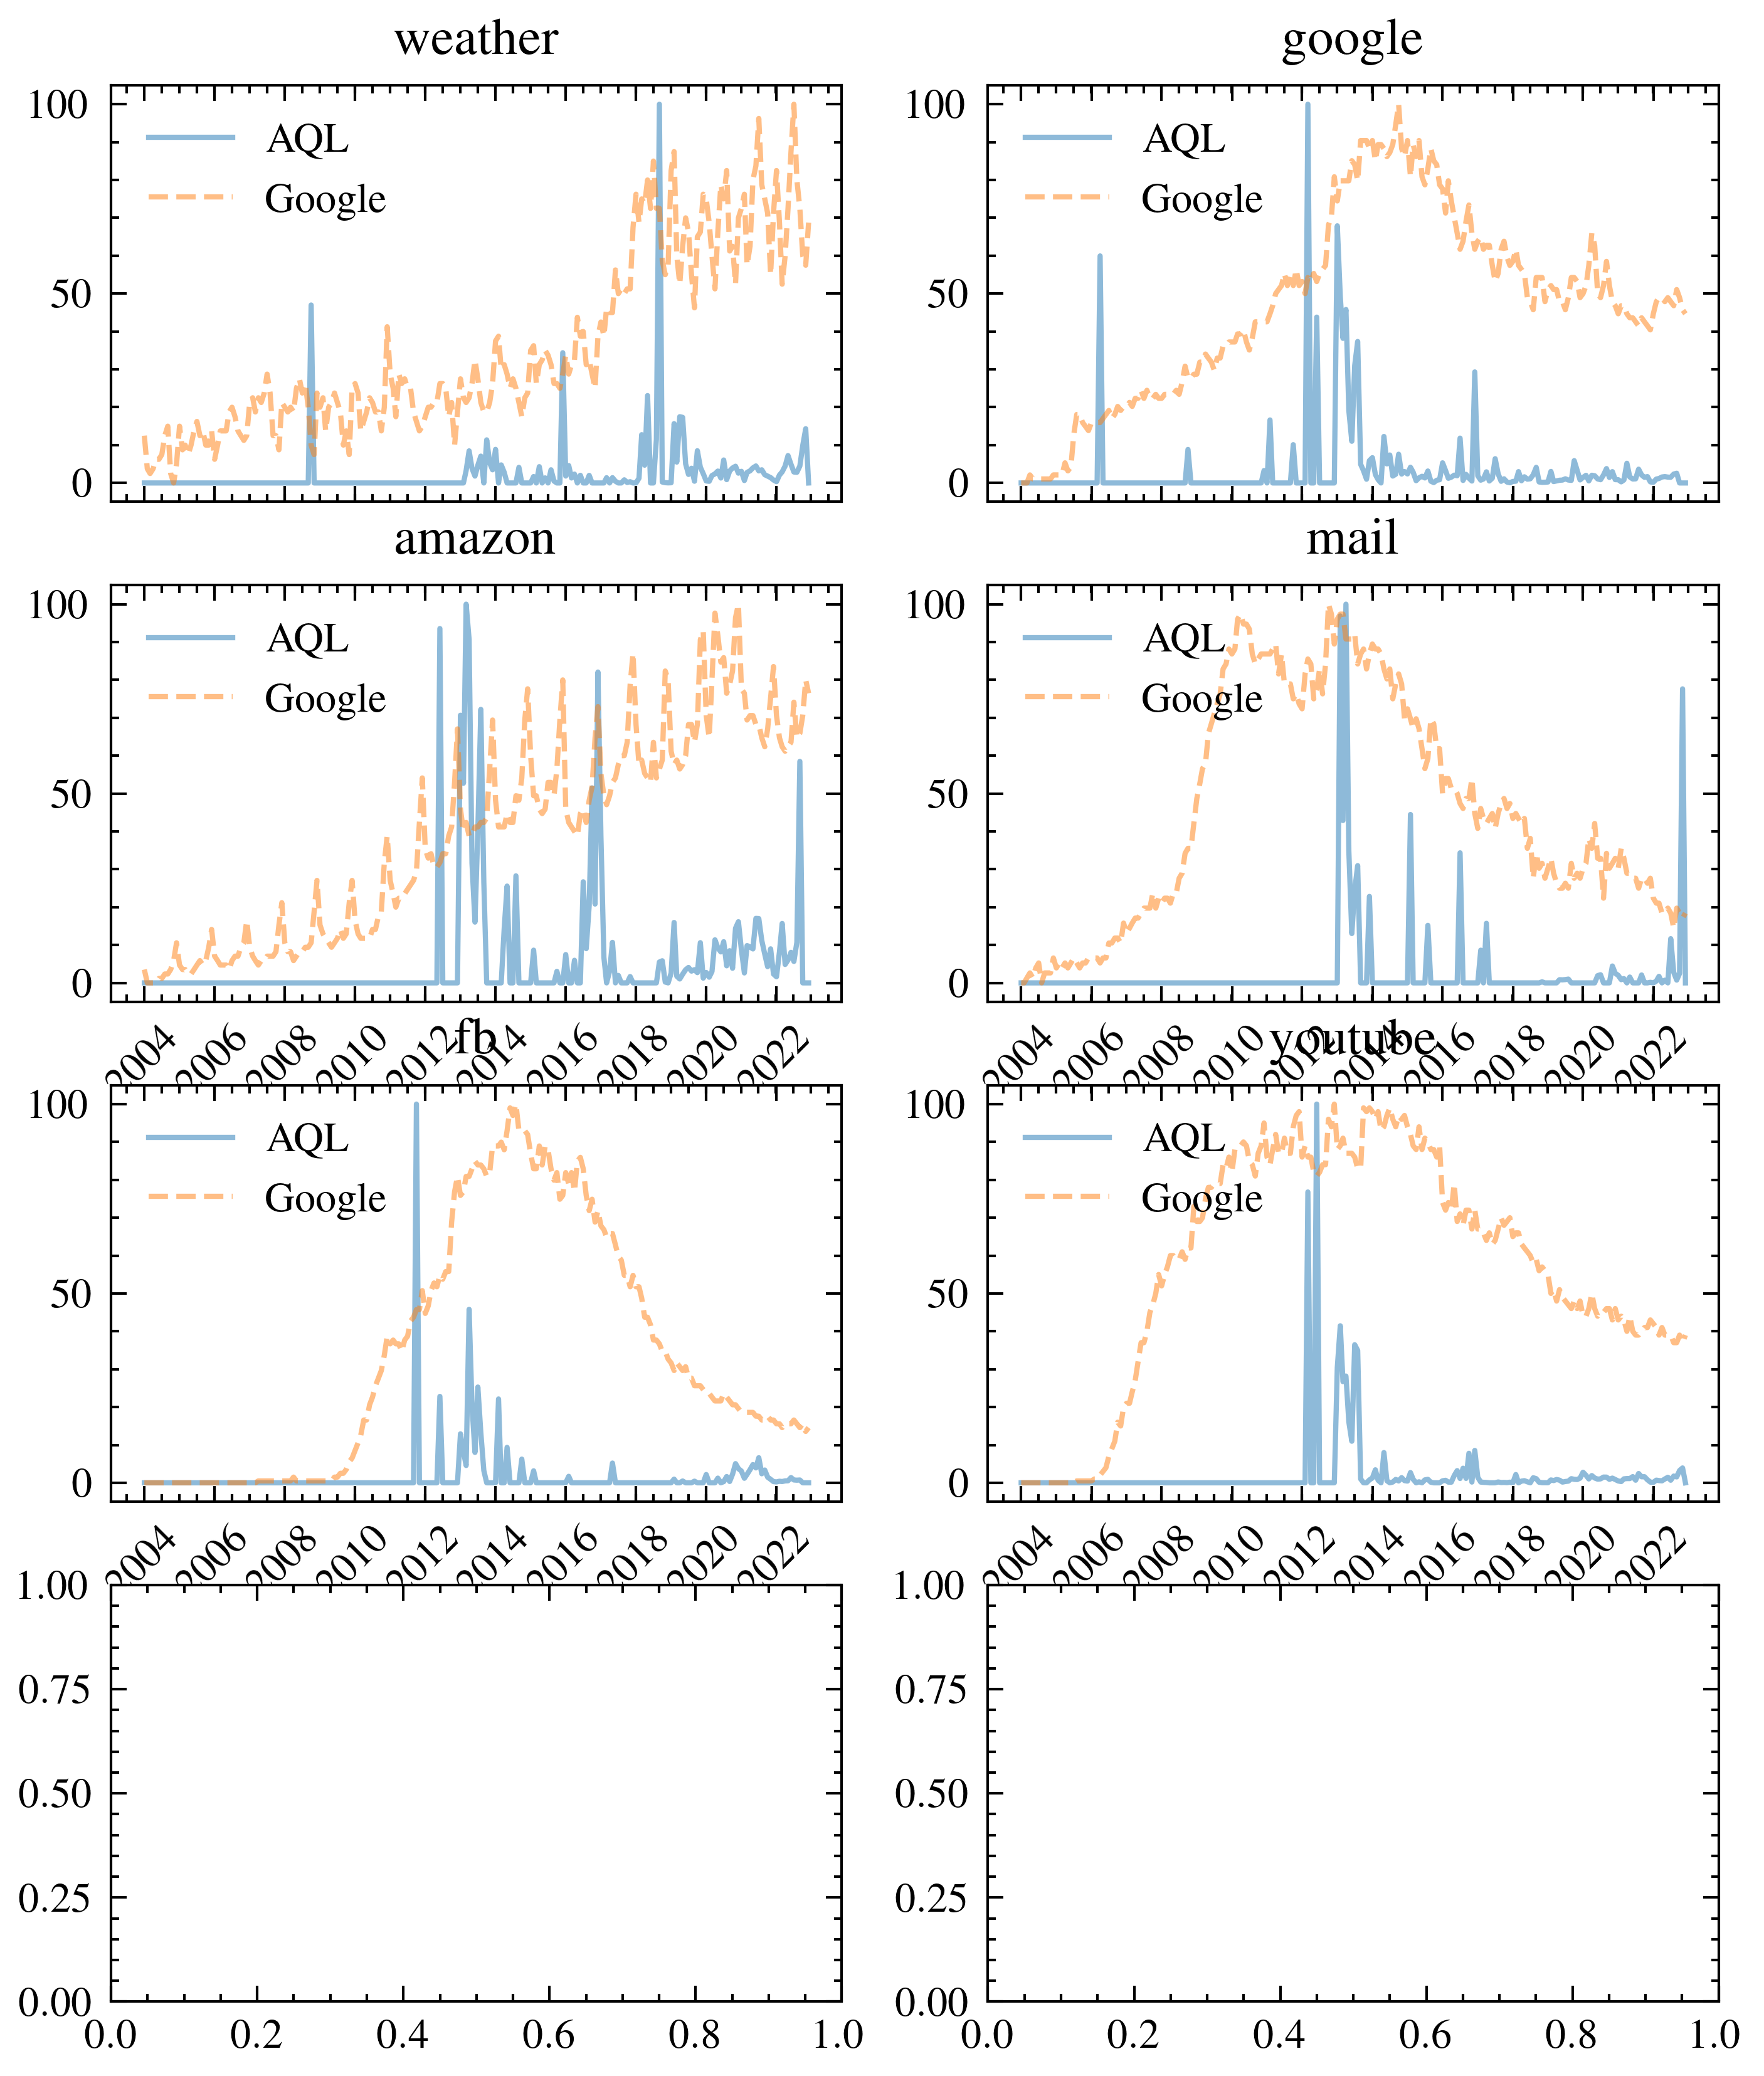

In [12]:
import matplotlib.pyplot as plt
import scienceplots
from pathlib import Path

# Extract the query names with 4 highest correlations
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
queries = [query for query, _ in sorted_results[4:10]]
print(queries)

# save_vis = False
save_vis = True
# plot_format = 'pgf'
plot_format = 'pdf'

analysis_name = "time-series-google-trends"

# Set size of plot
textwidth = 5.5129
aspect_ratio = 6 / 8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio *0.8*2

# Use science style for plots from scienceplots library
plt.style.use(["science", "ieee"])  # "grid", "ieee",

color = ['tab:blue', 'tab:orange']


fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(width, height))

# Iterate over axes and plot data
for i, ax in enumerate(axes.flatten()):
    # Get time series
    aql_time_series = aql_google_data[queries[i]]['count()']
    google_time_series = df_time_series.query(f"query == '{queries[i]}'")['score']

    # Standardize the time series
    # aql_time_series = (aql_time_series - aql_time_series.mean()) / aql_time_series.max()
    # google_time_series = (google_time_series - google_time_series.mean()) / google_time_series.std()
    # Normalize the time series to [0,100]
    aql_time_series = (aql_time_series - aql_time_series.min()) / (aql_time_series.max() - aql_time_series.min()) * 100
    google_time_series = (google_time_series - google_time_series.min()) / (google_time_series.max() - google_time_series.min()) * 100

    # Plot the time series
    ax.plot(aql_google_data[queries[i]]['time'], aql_time_series, label='AQL', color=color[0], alpha=0.5)
    ax.plot(pd.to_datetime(df_time_series.query(f"query == '{queries[i]}'")['time']), google_time_series, label='Google', color=color[1], alpha=0.5)

    # Add query as title
    ax.set_title(queries[i], fontweight='bold', fontsize=10)

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # remove xticks if not the last row
    if i < 2:
        ax.set_xticklabels([])

    # Add legend to each subplot
    ax.legend(loc='upper left', fontsize=8)

# Set global labels
# fig.supxlabel('Time', y=0.05)
fig.supylabel('Frequency', x=0.03)

plt.tight_layout()
# Either save visualization or show it
plt.show()

if save_vis:
    vis_dir = Path(f"/home/benjamin/studium/masterarbeit/thesis-schneg/plots/{analysis_name}")
    # Make directory if it does not exist
    if not vis_dir.exists():
        vis_dir.mkdir(parents=True)
    # Delete old plot
    for file in vis_dir.iterdir():
        if file.is_file() and file.name.endswith(f'.{plot_format}'):
            file.unlink()

    fig.savefig(vis_dir.joinpath(f"all.{plot_format}"), format=plot_format)